# Load MNIST handwritten digits dataset

(60000, 28, 28, 1) (60000,)


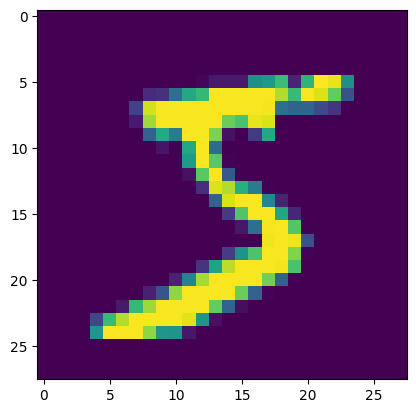

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import numpy as np
# Plot train and test loss
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[..., None] / 255.
X_test = X_test[..., None] / 255.
x = X_train[:100]
y = y_train[:100]

print(X_train.shape, y_train.shape)
_ = plt.imshow(X_train[0, ..., 0], cmap='viridis')

# Define our autoencoder model

Basically, we model:

$$\hat{y} = f_D( \underbrace{f_E(x)}_{z} )$$

Where $f_E$ is the encoder and $f_D$ is the decoder.

In [2]:
from functools import reduce
from typing import Iterable
from keras import layers as L
from keras import Model


def encoder(latent_dim: int = 8, noise_std=0.05, dropout=0.2) -> Model:
    inputs = L.Input(shape=(28,28,1))
    x = L.Flatten()(inputs)
    x = L.GaussianNoise(noise_std)(x)
    x = L.BatchNormalization()(x)

    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.LayerNormalization()(x)

    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim * 4, activation='relu')(x)
    x = L.LayerNormalization()(x)
    
    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim, activation='linear')(x)
    x = L.LayerNormalization()(x)
    
    model = Model(inputs=inputs, outputs=x, name='encoder')
    return model


def decoder(latent_dim: int = 8, output_dim: Iterable[int] = (28, 28, 1), dropout=0.2, noise_std=0.05) -> Model:
    output_dim_size: int = reduce(lambda x, y: x * y, output_dim)
    inputs = L.Input(shape=(latent_dim,))
    
    x = L.GaussianNoise(noise_std)(inputs)

    x = L.Dense(latent_dim * 4, activation='relu')(x)
    x = L.Dropout(dropout)(x)
    x = L.LayerNormalization()(x)
    
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.Dropout(dropout)(x)
    x = L.LayerNormalization()(x)

    x = L.Dense(output_dim_size, activation='sigmoid')(x)
    x = L.Reshape(output_dim)(x)
    
    model = Model(inputs=inputs, outputs=x, name='decoder')
    return model


In [3]:
latent_dim: int = 30
image_dim: Iterable[int] = (28, 28, 1)

e = encoder(latent_dim=latent_dim)
d = decoder(latent_dim=latent_dim)

z = e(x)
x_hat = d(z)

print("Encoder: {} -> {}".format(x.shape, z.shape))
print("Decoder: {} -> {}".format(z.shape, x_hat.shape))

2024-01-28 13:19:19.291569: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-28 13:19:19.291593: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-28 13:19:19.291603: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-28 13:19:19.291633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-28 13:19:19.291651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Encoder: (100, 28, 28, 1) -> (100, 30)
Decoder: (100, 30) -> (100, 28, 28, 1)


# Train our autoencoder model

In [4]:
inputs = L.Input(shape=image_dim)
z = e(inputs)
outputs = d(z)

autoencoder = Model(inputs=inputs, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 30)                442546    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         440104    
                                                                 
Total params: 882650 (3.37 MB)
Trainable params: 881082 (3.36 MB)
Non-trainable params: 1568 (6.12 KB)
_________________________________________________________________


In [5]:
history = autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=5,
    validation_data=(X_test, X_test),
)

Epoch 1/5


2024-01-28 13:19:21.002457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0737 - val_loss: 0.0551
Epoch 2/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0584 - val_loss: 0.0529
Epoch 3/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0569 - val_loss: 0.0514
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0555 - val_loss: 0.0516
Epoch 5/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0550 - val_loss: 0.0516


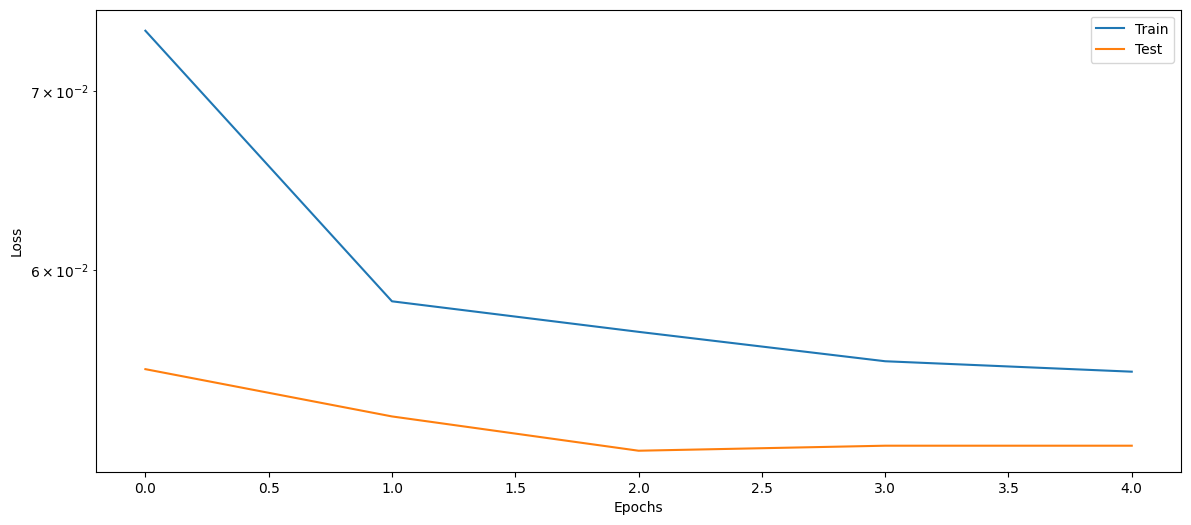

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')

# log scale
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# We can now easily train a naive classifier on the latent space representations

In [7]:
z_train = e.predict(X_train)
z_test = e.predict(X_test)
z = e.predict(x)

z_train.shape

4/4 [==============================] - 0s 61ms/step


(60000, 30)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

for cls in (LogisticRegression, KNeighborsClassifier, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis):
    name = cls.__name__
    
    classifier = cls().fit(z_train, y_train)
    roc_auc = roc_auc_score(y_test, classifier.predict_proba(z_test), multi_class='ovr')
    
    print("{}: {:.4f}".format(name, roc_auc))

LogisticRegression: 0.9887
KNeighborsClassifier: 0.9928
LinearDiscriminantAnalysis: 0.9855
QuadraticDiscriminantAnalysis: 0.9975


# 

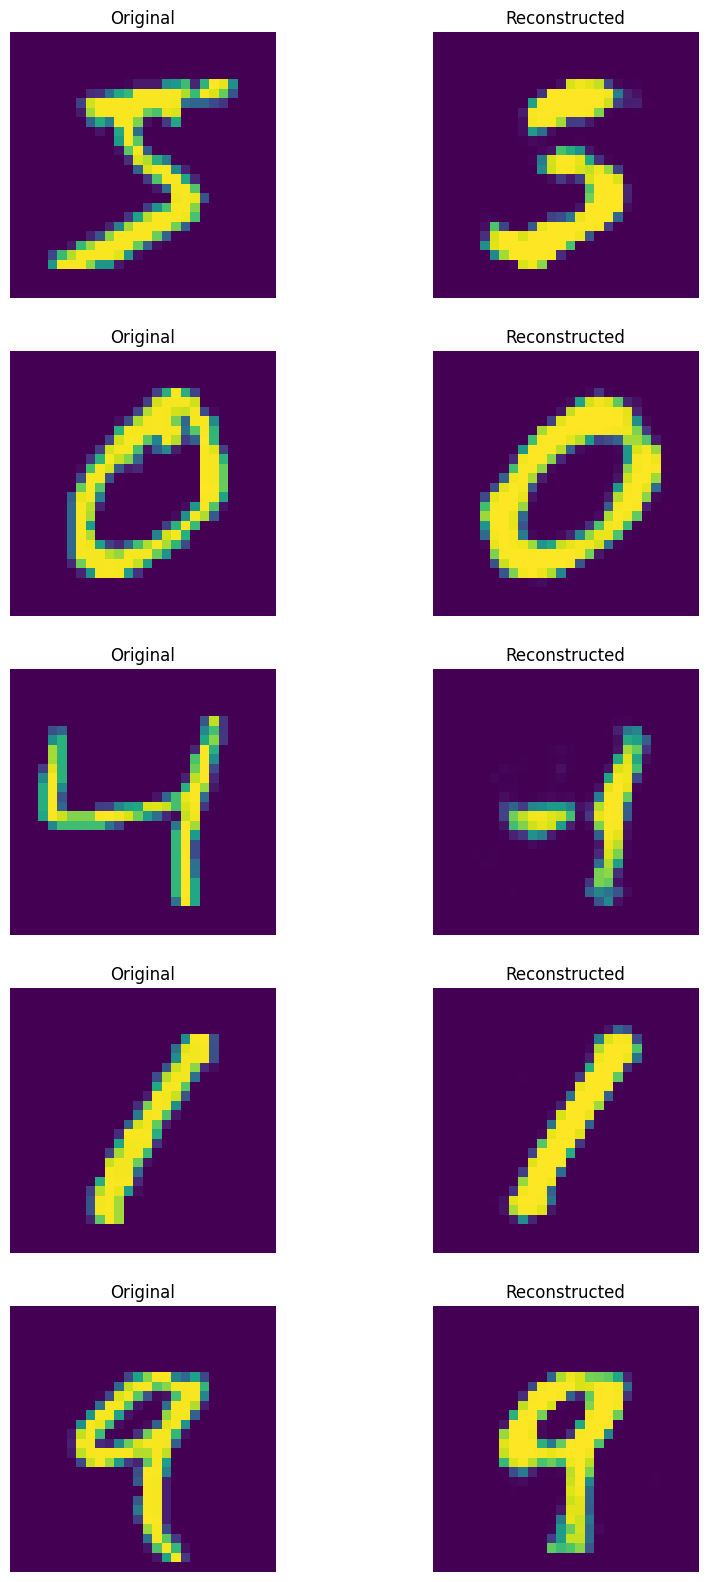

In [9]:
n_images: int = 5

# Show them side by side
fig, ax = plt.subplots(n_images, 2, figsize=(10, 20))

x_hat = autoencoder.predict(X_train[:n_images], verbose=0)

for i in range(n_images):
    label = y_train[i]
    ax[i, 0].imshow(X_train[i, ..., 0], cmap='viridis')
    ax[i, 1].imshow(x_hat[i, ..., 0], cmap='viridis')

    ax[i, 0].set_title('Original')
    ax[i, 1].set_title('Reconstructed')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

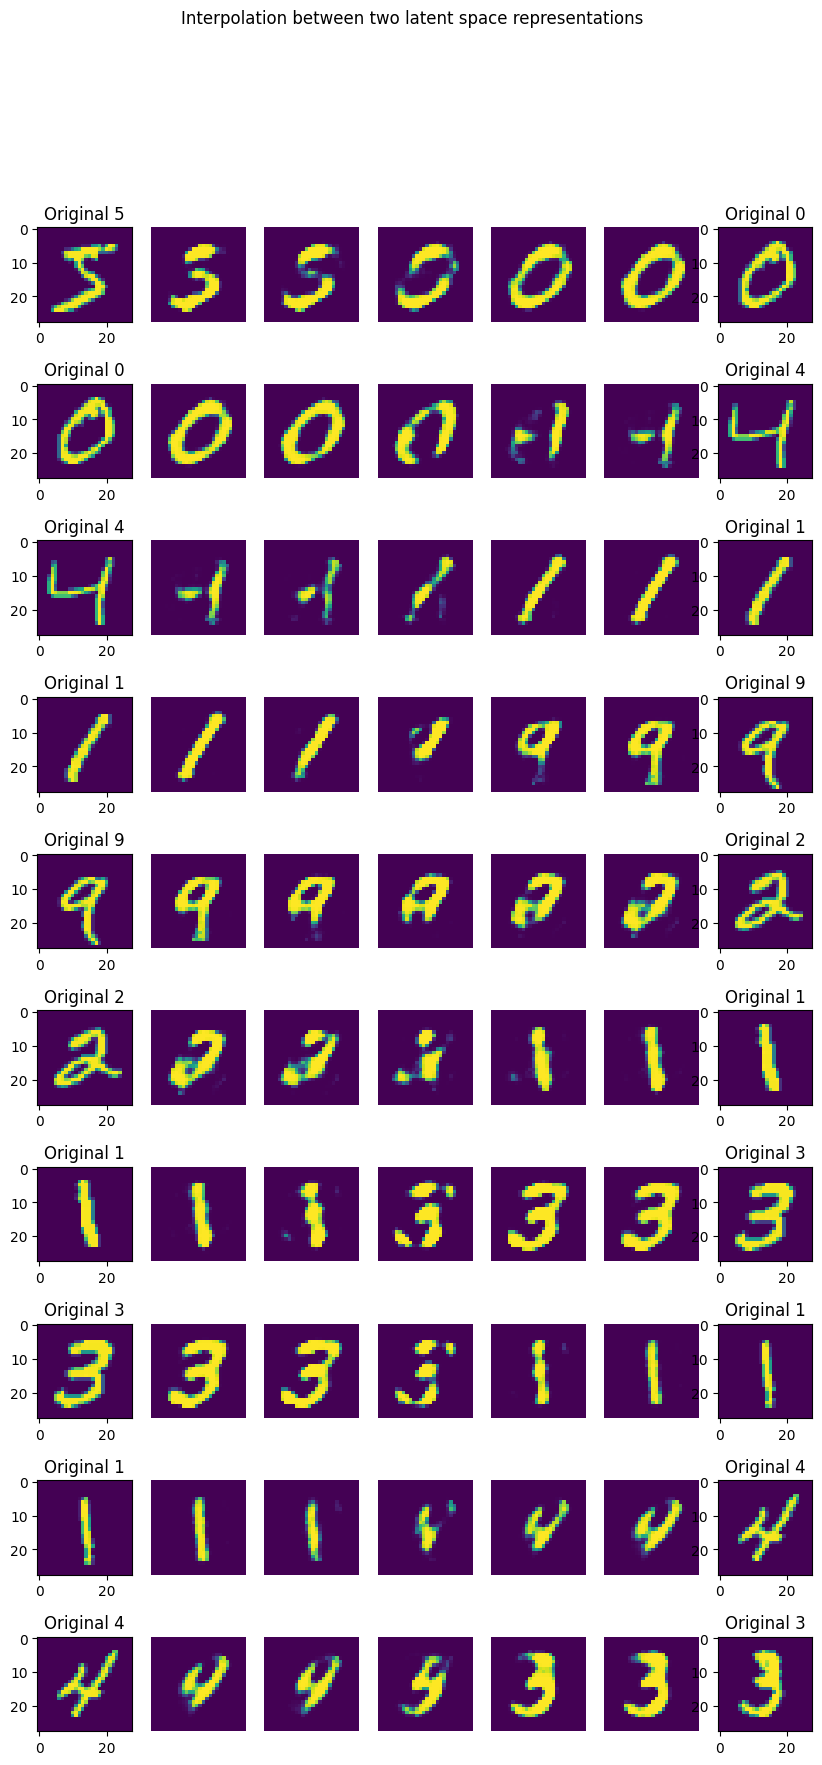

In [10]:
n_steps: int = 5
n_images: int = 10

fig, axs = plt.subplots(n_images, n_steps + 2, figsize=(10, 20))

for idx in range(n_images):
    a_original = x[idx]
    a_label = y[idx]
    b_original = x[idx + 1]
    b_label = y[idx + 1]
    a = z[idx]
    b = z[idx + 1]
    z_hat = a + (b - a) * np.linspace(0, 1, n_steps)[:, None]
    x_hat = d.predict(z_hat, verbose=0)
    
    axs[idx, 0].imshow(a_original[..., 0], cmap='viridis')
    axs[idx, 0].set_title('Original {}'.format(a_label))

    for i in range(n_steps):
        axs[idx, i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
        axs[idx, i + 1].axis('off')
        
    axs[idx, -1].imshow(b_original[..., 0], cmap='viridis')
    axs[idx, -1].set_title('Original {}'.format(b_label))

_ = fig.suptitle('Interpolation between two latent space representations')

# Visualizing the Principal Components of the Latent Space

In [11]:
from sklearn.decomposition import PCA
n_pca_components: int = 10

pca = PCA(n_components=n_pca_components).fit(z_train)

pca

PCA(n_components=10)

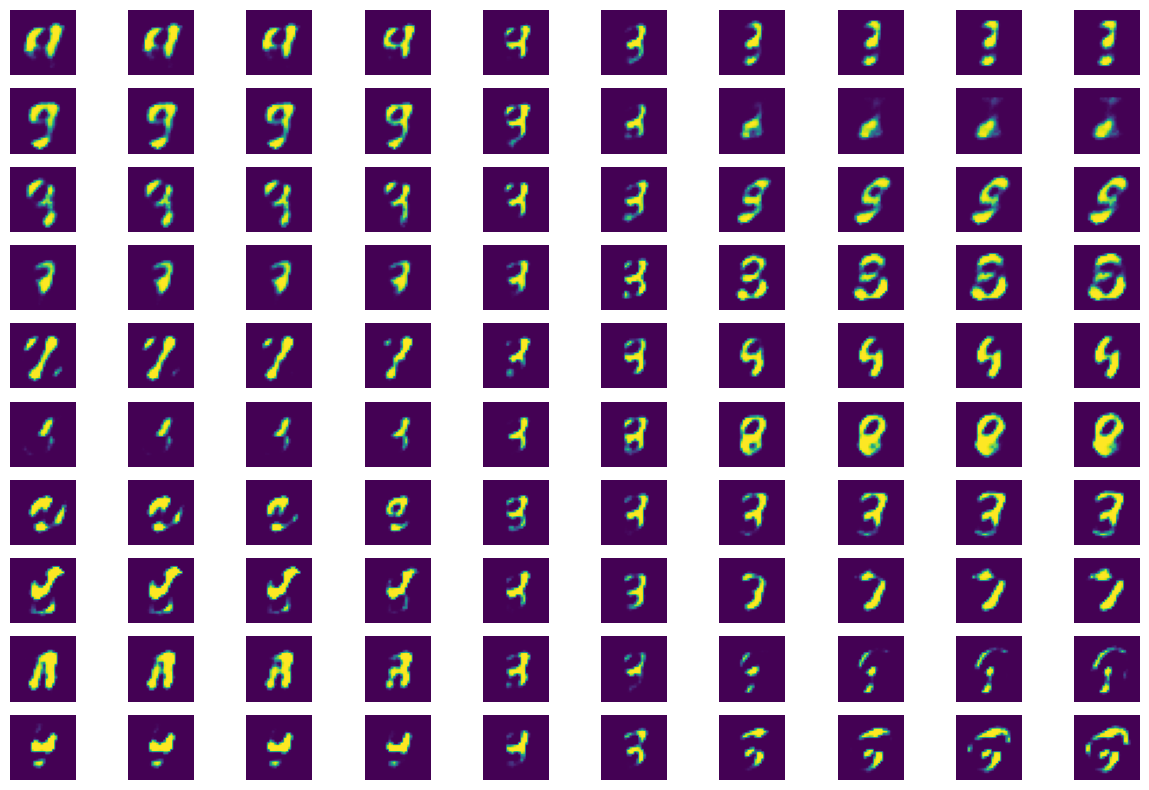

In [12]:
# z_0 = z_train[1]
# z_0 = np.zeros_like(z_train[1])
z_0 = np.mean(z_train, axis=0)
n_steps: int = 10
t: float = 5

fig, axs = plt.subplots(n_pca_components, n_steps, figsize=(15, 10))

for pc_idx in range(n_pca_components):
    pc_a = pca.components_[pc_idx]

    z_hat = z_0 + pc_a * np.linspace(-t, t, n_steps)[:, None]
    x_hat = d.predict(z_hat, verbose=0)

    for i in range(n_steps):
        axs[pc_idx, i].imshow(x_hat[i, ..., 0], cmap='viridis')
        axs[pc_idx, i].axis('off')

1/1 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Mean 2')

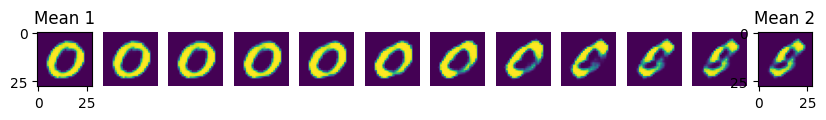

In [13]:
from sklearn.cluster import KMeans

n_means = 10

kmeans = KMeans(n_clusters=n_means).fit(z_train)

# And morph from mean 1 to mean 2
z_mean_1 = kmeans.cluster_centers_[0]
z_mean_2 = kmeans.cluster_centers_[1]
z_hat = z_mean_1 + (z_mean_2 - z_mean_1) * np.linspace(0, 1, n_steps)[:, None]
x_hat = d.predict(z_hat, verbose=0)

fig, axs = plt.subplots(1, n_steps + 2, figsize=(10, 2))

axs[0].imshow(d.predict(z_mean_1[None, ...])[0, ..., 0], cmap='viridis')
axs[0].set_title('Mean 1')

for i in range(n_steps):
    axs[i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
    axs[i + 1].axis('off')

axs[-1].imshow(d.predict(z_mean_2[None, ...])[0, ..., 0], cmap='viridis')
axs[-1].set_title('Mean 2')

# Scatter plot with the images as markers

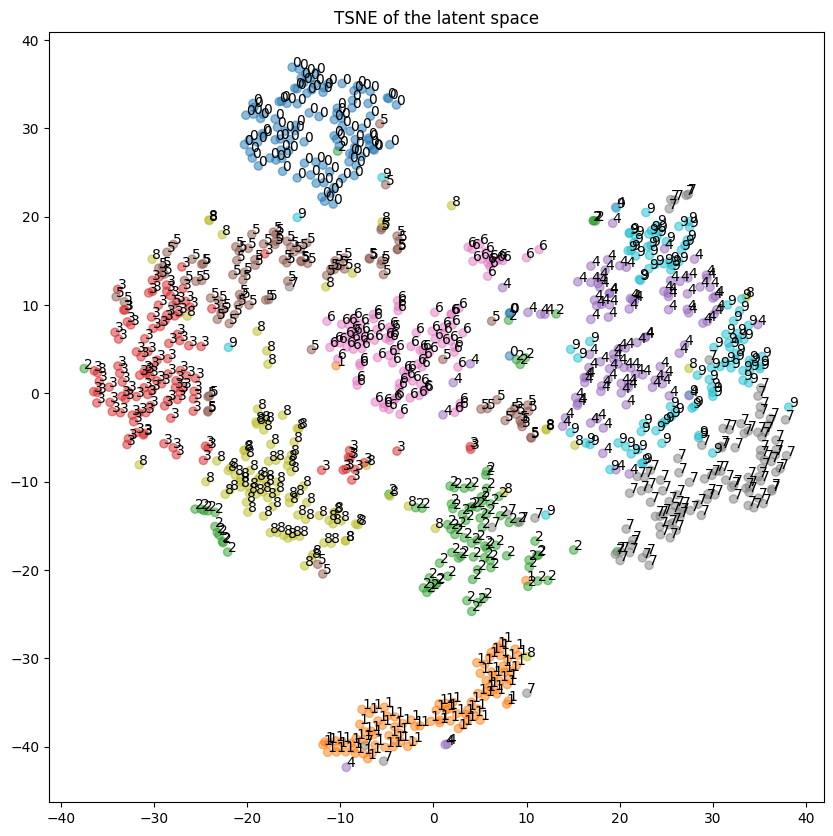

In [14]:
from sklearn.manifold import TSNE

n_samples: int = 1000

idxs = np.random.choice(np.arange(len(z_test)), size=n_samples, replace=False)
t = TSNE(n_components=2).fit_transform(z_test[idxs])

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(t[:, 0], t[:, 1], c=y_test[idxs], cmap='tab10', alpha=0.5)
ax.set_title('TSNE of the latent space')

# And plot the labels
for i in range(n_samples):
    ax.annotate(str(y_test[idxs][i]), (t[i, 0], t[i, 1]))

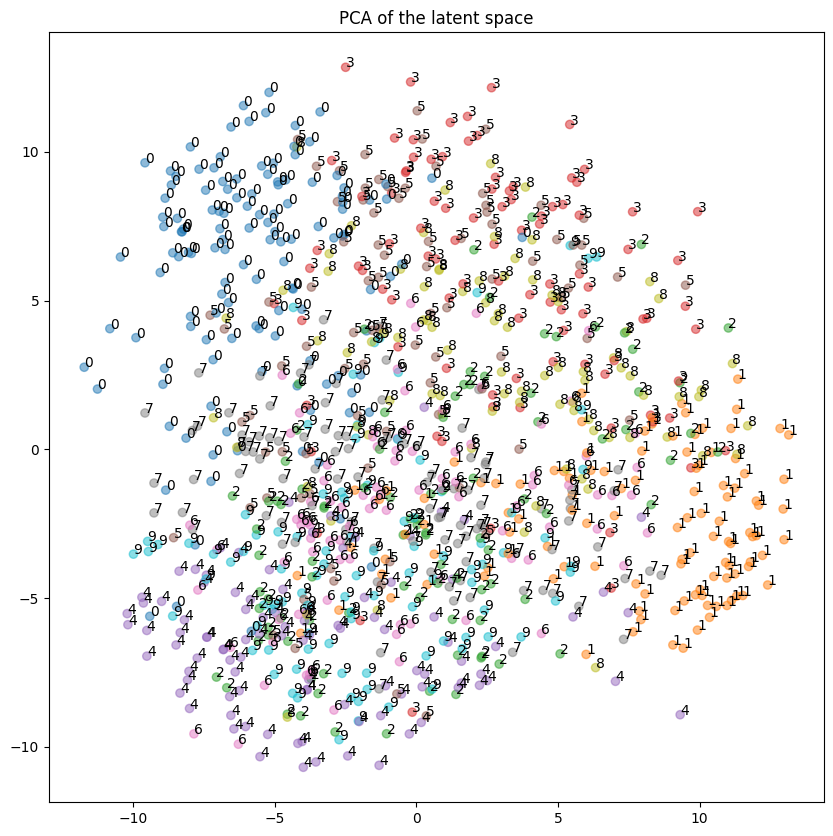

In [15]:
# And the same with PCA
from sklearn.decomposition import PCA

n_samples: int = 1000

idxs = np.random.choice(np.arange(len(z_test)), size=n_samples, replace=False)

pca = PCA(n_components=2).fit_transform(z_test[idxs])

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(pca[:, 0], pca[:, 1], c=y_test[idxs], cmap='tab10', alpha=0.5)
ax.set_title('PCA of the latent space')

# And plot the labels
for i in range(n_samples):
    ax.annotate(str(y_test[idxs][i]), (pca[i, 0], pca[i, 1]))